### Moran-Felsenszwalb tissue domain segmentation workflow

Here is a computationally efficient implementation of the Moran-Felsenszwalb workflow. 

In [1]:
# Standard library imports
import time
import pickle
import random
from pathlib import Path

# Third-party imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.measure import label
from scipy import stats

# Import necessary Moran Imaging modules
from moran_imaging.fast_moran_felzenszwalb_segmentation import get_moran_felzenszwalb_segmentation

In [2]:
# Fix random seed
random.seed(0)

# Seaborn plotting style
sns.set(style="whitegrid", font_scale=1)

# Define number of clusters
num_clusters = 15

# Define colormaps
colormap_reverse = sns.blend_palette([".99", "darkblue"], as_cmap=True)
num_viridis = int(np.floor(num_clusters/2))
num_coolwarm = int(num_clusters - num_viridis)
viridis = plt.get_cmap('viridis_r', num_viridis) 
coolwarm = sns.color_palette('coolwarm', as_cmap=True)(np.linspace(0, 1, num_coolwarm))
combined_colors = np.vstack([viridis(np.linspace(0, 1, num_viridis)), coolwarm])
combined_cmap = ListedColormap(combined_colors)

In [3]:
def kmeans_superpixel_coloring(segments, cluster_labels, num_pixels, background_mask): 
    segmentation_labels = label(segments).flatten()[np.invert(background_mask)]
    mapping_pixel_to_segment = segmentation_labels
    all_segment_labels = np.unique(mapping_pixel_to_segment)
    dict_segment_to_pixels = {}
    for segment_label in all_segment_labels: 
        dict_segment_to_pixels[segment_label] = mapping_pixel_to_segment == segment_label

    segment_label_dict = {}
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        pixel_labels_segment = cluster_labels[mask_segment]
        cluster_segment_label = stats.mode(pixel_labels_segment)[0]
        segment_label_dict[segment_label] = cluster_segment_label

    final_cluster_labels = np.zeros(num_pixels)
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        final_cluster_labels[mask_segment] = segment_label_dict[segment_label]
        
    return final_cluster_labels

#### Load imaging mass spectrometry data

In [4]:
data_dir = Path(".").resolve() / "Data"
assert data_dir.exists(), f"The data directory {data_dir} does not exist."

pickle_file = data_dir / "Zebra_fish_UMAP_dataset.pickle"
assert pickle_file.exists(), f"The pickle file {pickle_file} does not exist."

with open(pickle_file, 'rb') as handle:
    zebra_fish_dict = pickle.load(handle)

image_shape = zebra_fish_dict['image_shape'] 
background_mask = zebra_fish_dict['background_mask'] 
pixel_order = zebra_fish_dict['pixel_order']  
dataset_UMAP = zebra_fish_dict['dataset_UMAP'] 
acquisition_mask = np.invert(background_mask)
num_pixels = dataset_UMAP.shape[0]

/var/folders/dz/cj459n9s6977wdf9bgw0bnym0000gp/T/ipykernel_713/4100663250.py:8: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  zebra_fish_dict = pickle.load(handle)


#### Fast Moran-Felsenszwalb segmentation 

In [5]:
mask = np.reshape(acquisition_mask, image_shape).astype(bool)
#dataset_UMAP = dataset_UMAP[:, [0, 1, 2, 4, 7]]
image = np.zeros((dataset_UMAP.shape[1], *image_shape))
image[:, mask] = dataset_UMAP.T

start_time = time.time()
segmentation = get_moran_felzenszwalb_segmentation(image, mask, num_clusters, neighbourhood_type="queen", neighbourhood_order=5, felzenszwalb_scale=40, 
                                                   felzenszwalb_sigma=0.2, felzenszwalb_min_size=80, subset_features = [0, 1, 2, 4, 7])
end_time = time.time()
segmentation_time = end_time - start_time
print('Runtime:', segmentation_time)

/Users/lgmigas/Documents/GitHub/Moran_Imaging/src/moran_imaging/fast_moran_felzenszwalb_segmentation.py:100: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.
  felzenszwalb_segmentation = skimage.segmentation.felzenszwalb(


Runtime: 53.55319380760193


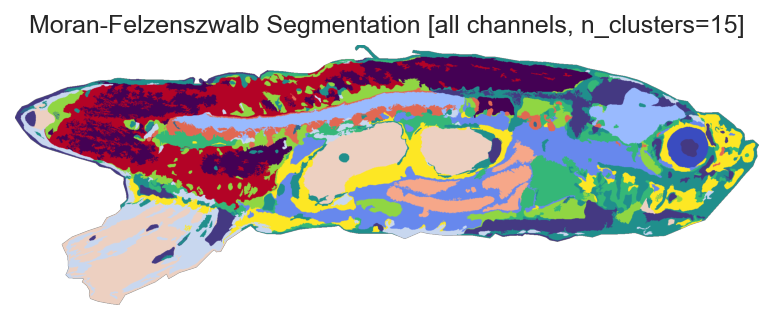

In [6]:
# Plot results
plt.figure(dpi=150)
segmentation = np.ma.array(segmentation, mask=~mask)
plt.imshow(segmentation, cmap=combined_cmap)
plt.title(f"Moran-Felzenszwalb Segmentation [all channels, n_clusters={num_clusters}]")
plt.axis("off")
plt.show()